# MGDB curation



This notebook shows how to use LLM to infer host categories (purple column) given sample and study information (blue columns) when metagenome is unknown.
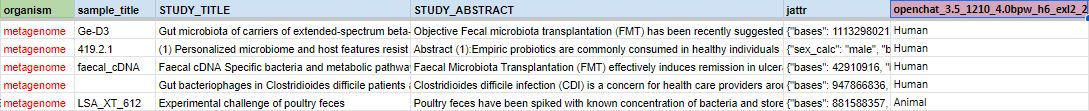


Host Categories:


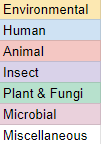

Library to run LLM for inference: [exllamav2](https://github.com/turboderp/exllamav2)

## Prepare Necessary package

### Prepare data for curation


In [ ]:
import pandas as pd
# https://docs.google.com/spreadsheets/d/1DI0hG1lind_c8Eg35t2-ZGTTBmlsHjznMoqbl4bPXBo/edit?usp=sharing
gsheetkey = '1DI0hG1lind_c8Eg35t2-ZGTTBmlsHjznMoqbl4bPXBo'
url=f'https://docs.google.com/spreadsheet/ccc?key={gsheetkey}&output=xlsx'
tabs = pd.ExcelFile(url).sheet_names
sheets=[]
for sheet in tabs:
  if 'metagenome_set1' in sheet:
    sheets.append(sheet)

In [ ]:
data = []
for sheet in sheets:
  df = pd.read_excel(url,sheet_name=sheet)
  df = df.sample(200)
  data.append(df)

### Download [exllamav2-compatible model](https://huggingface.co/LoneStriker/)

In [ ]:
!git lfs install
!git clone https://huggingface.co/LoneStriker/openchat-3.5-1210-3.0bpw-h6-exl2-2

Git LFS initialized.
Cloning into 'openchat-3.5-1210-3.0bpw-h6-exl2-2'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 5), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (22/22), 12.18 KiB | 1.74 MiB/s, done.


### Download exllamav2 package for running quantized LLM

In [ ]:
!pip install exllamav2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


### Example inference code using exllamav2
*import exllamav2 make takes 3-4 minutes*

In [ ]:

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from exllamav2 import(
    ExLlamaV2,
    ExLlamaV2Config,
    ExLlamaV2Cache,
    ExLlamaV2Tokenizer,
)

from exllamav2.generator import (
    ExLlamaV2BaseGenerator,
    ExLlamaV2Sampler
)

import time

# Initialize model and cache

model_directory =  "/content/openchat-3.5-1210-3.0bpw-h6-exl2-2"

config = ExLlamaV2Config()
config.model_dir = model_directory
config.prepare()

model = ExLlamaV2(config)
print("Loading model: " + model_directory)

cache = ExLlamaV2Cache(model, lazy = True)
model.load_autosplit(cache)

tokenizer = ExLlamaV2Tokenizer(config)

# Initialize generator

generator = ExLlamaV2BaseGenerator(model, cache, tokenizer)

# Generate some text

settings = ExLlamaV2Sampler.Settings()
settings.temperature = 0.85
settings.top_k = 50
settings.top_p = 0.8
settings.token_repetition_penalty = 1.05
settings.disallow_tokens(tokenizer, [tokenizer.eos_token_id])

prompt = "Our story begins in the Scottish town of Auchtermuchty, where once"

max_new_tokens = 150

generator.warmup()
time_begin = time.time()

output = generator.generate_simple(prompt, settings, max_new_tokens, seed = 1234)

time_end = time.time()
time_total = time_end - time_begin

print(output)
print()
print(f"Response generated in {time_total:.2f} seconds, {max_new_tokens} tokens, {max_new_tokens / time_total:.2f} tokens/second")


Loading model: /content/openchat-3.5-1210-3.0bpw-h6-exl2-2
Our story begins in the Scottish town of Auchtermuchty, where once upon a time a wee girl named Alison lived. Alison was a curious child who loved animals and spent her days exploring the countryside. She dreamed of being a veterinarian and caring for all the creatures she encountered. Alison also had a special gift for making people laugh with her funny stories and jokes.

One day Alison's family moved to a new town. She missed her old friends and the familiar faces at school. But her new home had a beautiful garden with lots of animals. A cat named Whiskers, a dog named Benny, and a flock of chickens named Tilly, Daisy, and Henny lived there too. Alison quickly made friends with all her new neighbors

Response generated in 2.59 seconds, 150 tokens, 58.02 tokens/second


## LLM inference
Following shows how LLM infers category from given information.

The inference is divided into 2 stages.

###Stage Explanation

#### Stage 1
Given 4 feature, LLM output its predicted category

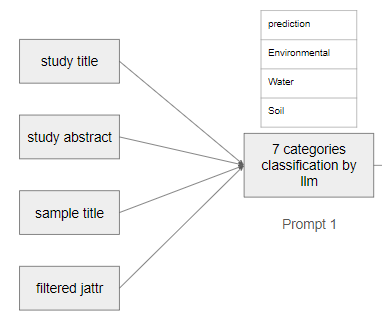

####Stage 2

Correct LLM-invent category into 7 categories

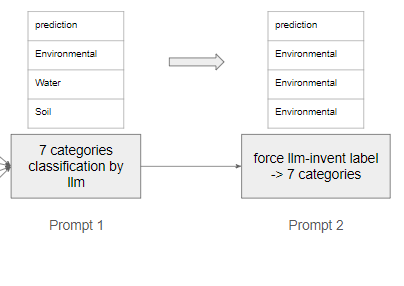

### Load model

In [ ]:
import torch
import time
import random
import re
import pandas as pd
import os
model_directory =  "/content/openchat-3.5-1210-3.0bpw-h6-exl2-2"
print("Loading model: " + model_directory)

model.load()

tokenizer = ExLlamaV2Tokenizer(config)

# Create some sampling settings

settings_proto = ExLlamaV2Sampler.Settings()
settings_proto.temperature = 0.001
settings_proto.top_p = 1
settings_proto.top_k = 100
settings_proto.token_repetition_penalty = 1.2
# settings_proto.mirostat = True
# settings_proto.mirostat_tau = 5
# settings_proto.top_k = 1000

Loading model: /content/openchat-3.5-1210-3.0bpw-h6-exl2-2


### Function label from llm output
The predicted label is quoted in model output, this function will extract the prediction from LLM output

E.g. "Human". \<end_of_turn> -> Human

In [ ]:
def get_substring_inside_first_quote(string):
    quote_chars = ['"', "'"]
    for quote_char in quote_chars:
        start_index = string.find(quote_char) + 1  # Find the index of the first quote and add 1 to skip it
        end_index = string.find(quote_char, start_index)  # Find the index of the next quote after the start index
        if start_index != 0 and end_index != -1:  # start_index will be 0 if quote_char is not found
            if string[start_index:end_index] =='Plant & Fungi':
                return string[start_index:end_index]
            else:
                return re.sub(r'[^a-zA-Z]','',string[start_index:end_index])  # Extract the substring using string slicing
    return "Miscellaneous"

### Formulate prompt for stage 1 and stage 2

In [ ]:
def formulate_prompt1(row):
  categories = '["Environmental", "Human", "Animal", "Insect", "Plant & Fungi", "Microbial", "Miscellaneous"]'
  prompt1_template = f'''
            GPT4 Correct User: You are a biological expert and you are provided with below label lists
            labels = {categories}
            Environmental is related to samples collected from natural environment for analysis. For example, water, soil, sludge, sediment and etc should be labelled as Environmental
            Plant & Fungi is referring to living organism that is plant or fungi.
            Don't mix up "Plant & Fungi" and "Environmental".
            Homo sapiens, human or human-related parts and organ should be labelled as Human.
            Insect, bugs, insect-related organ and parts should be labelled as Insect.
            Animal other than Insect or Human should be labelled as Animal.
            Don't mix up "Animal" and "Insect".
            Microbial refers to tiny living microrganisms, such as bacteria, viruses, and protists, that play important roles in ecological processes and can impact human health.
            Other objects should be labelled as Miscellaneous
            Your task is to choose one most appropriate label for the host organism that the metagenome is associated with below sample title, study title ,study description and
            json attributues of host from the labels list. Do not make up any new label.
            Pay more attention to sample title and json attributes of host if they are available when making the choice.
            sample title: {str(row['sample_title'])}
            study title: {str(row['study_title'])}
            study description: {str(row['study_abstract'])}
            json attributes of host: {str(row['jattr_filtered'])}
            do not give any explanation. <|end_of_turn|>
            GPT4 Correct Assistant: The most appropriate label of this host organism would be'''
  return prompt1_template

In [ ]:
def formulate_prompt2(label):
  categories = '["Environmental", "Human", "Animal", "Insect", "Plant & Fungi", "Microbial", "Miscellaneous"]'
  prompt2_template =  f'''
                GPT4 Correct User: You are a biological expert that give concise response and you are provided with below label lists
                labels = {categories},
                Environmental is related to samples collected from natural environment for analysis. For example, water, soil, sludge, sediment and etc should be labelled as Environmental
                Plant & Fungi is referring living organism that is plant or fungi.
                Think carefully to distinguish between "Plant & Fungi" and "Environmental".
                Homo sapiens, human or human-related parts and organ should be labelled as Human.
                Insect, bugs, insect-related parts should be labelled as Insect.
                Animal other than insect or human should be labelled as Animal.
                Think carefully to distinguish between "Animal" and "Insect".
                Microbial refers to tiny living microrganisms, such as bacteria, viruses, fungi, and protists, that play important roles in ecological processes and can impact human health.
                Other objects should be labelled as Miscellaneous
                Your task is to choose one most appropriate label for the term given. Do not make up any new label.
                Term: {label}
                Choose the most appropriate label for the host organism of the metagenome from the labels list <|end_of_turn|>
                GPT4 Correct Assistant: The most appropriate label for term from the labels list is'''
  return prompt2_template

In [ ]:
len(data)

8

### Start Curation

In [ ]:
for j in range(len(data)):
      print('sheet processing:',sheets[j])
      df = data[j]
      res = []
      all_prompts=[]

      # STAGE 1 curation

      # take sample ,study and jattr to formulate prompt for llm curation
      for _, row in df.iterrows():
          all_prompts.append(formulate_prompt1(row))
      # step determines number of prompt in each loop
      step=100
      start = 0

      start_time = time.time()
      for i in range(start,len(all_prompts),step):
          end = i+step
          if end>len(all_prompts):
              end=len(all_prompts)
          prompts=all_prompts[i:end]
          # number of prompts parallelly decode
          max_parallel_seqs = 16

          prompts_len = []

          # Active sequences and corresponding caches and settings

          input_ids = []
          caches = []
          settings = []

          # Stats
          indexes = list(range(end-i,-1,-1))
          order=[]
          labels=[]
          total_gen_tokens = 0
          total_prompt_tokens = 0
          prompt_time = 0
          token_time = 0

          # Continue generating as long as there is work to do

          while len(prompts) or len(input_ids):

              # If doing less than max_parallel_seqs, start some more. Prompt processing isn't batched in this example, but
              # would benefit much less from batching anyway

              while len(input_ids) < max_parallel_seqs and len(prompts):

                  time_begin = time.time()
                  # prompt to be processed pop from end of list
                  prompt = prompts.pop()

                  ids = tokenizer.encode(prompt)
                  prompts_len.append(len(prompt))
                  # ids.shape[1] + 7 -> max_new_tokens = 7
                  cache = ExLlamaV2Cache(model, max_seq_len = ids.shape[1]+7)  # (max_seq_len could be different for each cache)

                  model.forward(ids[:, :-1], cache, preprocess_only = True)

                  input_ids.append(ids)
                  caches.append(cache)
                  settings.append(settings_proto.clone())  # Need individual settings per prompt to support Mirostat

                  total_prompt_tokens += ids.shape[-1] -1
                  prompt_time += time.time() - time_begin

              # Create a batch tensor of the last token in each active sequence, forward through the model using the list of
              # active caches rather than a single, batched cache. Then sample for each token indidividually with some
              # arbitrary stop condition

              time_begin = time.time()

              inputs = torch.cat([x[:, -1:] for x in input_ids], dim = 0)
              logits = model.forward(inputs, caches, input_mask = None).float().cpu()

              eos = []
              r = random.random()
              for i in range(len(input_ids)):

                  token, _, _ = ExLlamaV2Sampler.sample(logits[i:i+1, :, :], settings[i], input_ids[i], r, tokenizer)
                  input_ids[i] = torch.cat([input_ids[i], token], dim = 1)
                  total_gen_tokens += 1
                  if caches[i].current_seq_len == caches[i].max_seq_len:
                      eos.insert(0, i)

              token_time += time.time() - time_begin

              # Output and drop any sequences completed in this step

              for i in eos:

                  output = tokenizer.decode(input_ids[i])[0]
                  labels.append(get_substring_inside_first_quote(output[prompts_len[i]:].strip()))
                  # finished order may not be follow the order of prompt
                  # append indexes of prompt to retreive order of decoding
                  order.append(indexes[i])
                  indexes.pop(i)
                  prompts_len.pop(i)
                  input_ids.pop(i)
                  caches.pop(i)
                  settings.pop(i)
          # print(f'prompt time: {prompt_time}')
          # print(f'token time: {token_time}')

          # sort decoded seq to follow original order
          sorted_list = [x for _, x in sorted(zip(order, labels))]

          # STAGE 2 Curation

          # get the indexes and labels that are out of 7 categories
          indexes = [i for i, el in enumerate(sorted_list) if el not in ['Environmental', 'Human', 'Animal', 'Insect', 'Plant & Fungi', 'Microbial', 'Miscellaneous']]
          indexes = indexes[::-1]
          labels = [el for el in sorted_list if el not in ['Environmental', 'Human', 'Animal', 'Insect', 'Plant & Fungi', 'Microbial', 'Miscellaneous']]

          prompts=[]

          # take these labels to formulate prompts to force llm-invent label to 7 categories
          # 'soil' -> 'Environmental'
          for label in labels:
              prompts.append(formulate_prompt2(label))
          max_parallel_seqs = 6


          prompts_len = []

          # Active sequences and corresponding caches and settings

          input_ids = []
          caches = []
          settings = []

          # Stats

          order=[]
          labels=[]
          total_gen_tokens = 0
          total_prompt_tokens = 0
          prompt_time = 0
          token_time = 0

          while len(prompts) or len(input_ids):

              # If doing less than max_parallel_seqs, start some more. Prompt processing isn't batched in this example, but
              # would benefit much less from batching anyway

              while len(input_ids) < max_parallel_seqs and len(prompts):

                  time_begin = time.time()

                  prompt = prompts.pop()
                  ids = tokenizer.encode(prompt)
                  # print(prompt)

                  prompts_len.append(len(prompt))
                  cache = ExLlamaV2Cache(model, max_seq_len = ids.shape[1] + 7)  # (max_seq_len could be different for each cache)

                  model.forward(ids[:, :-1], cache, preprocess_only = True)

                  input_ids.append(ids)
                  caches.append(cache)
                  settings.append(settings_proto.clone())  # Need individual settings per prompt to support Mirostat

                  total_prompt_tokens += ids.shape[-1] -1
                  prompt_time += time.time() - time_begin

              # Create a batch tensor of the last token in each active sequence, forward through the model using the list of
              # active caches rather than a single, batched cache. Then sample for each token indidividually with some
              # arbitrary stop condition

              time_begin = time.time()

              inputs = torch.cat([x[:, -1:] for x in input_ids], dim = 0)
              logits = model.forward(inputs, caches, input_mask = None).float().cpu()

              eos = []
              r = random.random()
              for i in range(len(input_ids)):

                  token, _, _ = ExLlamaV2Sampler.sample(logits[i:i+1, :, :], settings[i], input_ids[i], r, tokenizer)
                  input_ids[i] = torch.cat([input_ids[i], token], dim = 1)
                  total_gen_tokens += 1

                  if caches[i].current_seq_len == caches[i].max_seq_len:
                      eos.insert(0, i)

              token_time += time.time() - time_begin

              # Output and drop any sequences completed in this step

              for i in eos:

                  output = tokenizer.decode(input_ids[i])[0]
                  # print(output.strip())
                  labels.append(get_substring_inside_first_quote(output[prompts_len[i]:].strip()))
                  # print(i)
                  order.append(indexes[i])
                  indexes.pop(i)
                  # print(indexes)
                  prompts_len.pop(i)
                  input_ids.pop(i)
                  caches.pop(i)
                  settings.pop(i)
              sorted_label = [x for _, x in sorted(zip(order, labels))]

              # modify wrong label in stage 1 inference to label inferred in stage 2
              for i in range(len(order)):
                  sorted_list[order[i]] = sorted_label[i]

          # track decoding progress
          print(f'processed to {end-1}th')

          # append sorted list to res
          res.extend(sorted_list)


          torch.cuda.synchronize()
          torch.cuda.empty_cache()

          # sleep for 1 minutes for every 20000 loop
          # avoid gpu overheat
          if (end-start)%2000==0:
              print('sleeping')
              time.sleep(120)
              print('awake')
      df['inference_jattr_filtered'] = res
      data[j] = df

sheet processing: animal_metagenome_set1
processed to 99th
processed to 199th
sheet processing: env_metagenome_set1
processed to 99th
processed to 199th
sheet processing: fungi_metagenome_set1
processed to 99th
processed to 199th
sheet processing: plant_metagenome_set1
processed to 99th
processed to 199th
sheet processing: human_metagenome_set1
processed to 99th
processed to 199th
sheet processing: insect_metagenome_set1
processed to 99th
processed to 199th
sheet processing: microbial_metagenome_set1
processed to 99th
processed to 199th
sheet processing: misc_metagenome_set1
processed to 99th
processed to 199th


##Evaluation:

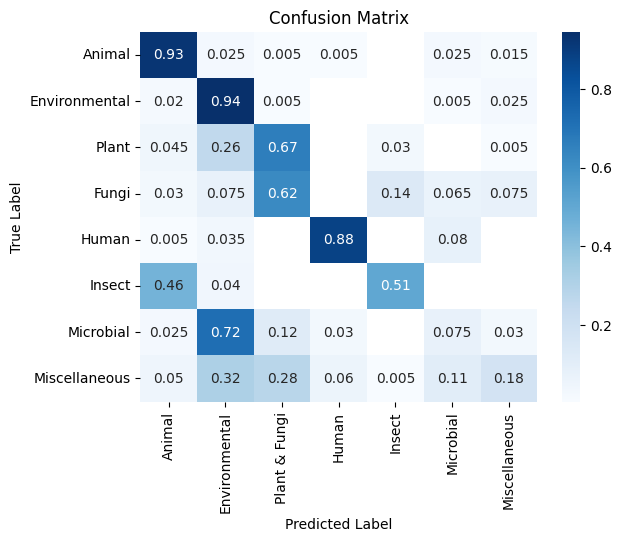

In [ ]:
# df has category as true label, inference_jattr_filtered as prediction
# generate confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


label_category = ["Animal","Environmental", "Plant & Fungi","Human","Insect", "Microbial", "Miscellaneous"]
true_category = ["Animal","Environmental", "Plant","Fungi","Human","Insect", "Microbial", "Miscellaneous"]
# Assuming you have a dataframe named df with 'category' as the true label and 'inference_jattr_filtered' as the predicted label
confusion_matrix_total = pd.DataFrame()

for i in range(len(sheets)):
    df = data[i]  # Assuming sheets is a list of dataframes
    confusion_matrix = pd.crosstab(df['category'], df['inference_jattr_filtered'])
    confusion_matrix_total = pd.concat([confusion_matrix_total, confusion_matrix])
index_list = confusion_matrix_total.index.tolist()
index_list[2] = 'Plant'
index_list[3] = 'Fungi'
confusion_matrix_total.index = index_list
confusion_matrix_total = confusion_matrix_total.reindex(columns=label_category, fill_value=0)
confusion_matrix_total = confusion_matrix_total.div(confusion_matrix_total.sum(axis=1), axis=0)
# Plot the confusion matrix using seaborn
sns.heatmap(confusion_matrix_total, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
